<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingNVPExtensionGaussianLikelihoodTestingVI_uncorrupted_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     \ 11.0MB 2.7MB/s


In [0]:
import corner

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0509 17:01:18.284738 140467102295936 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [5]:
generator_path = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path      = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [8]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 64
hidden_size = 10
sigma_n     = 0.1
n_channels  = 1
data_dim    = 28*28

sample_size_z = 64
lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()

# ----------------------------------------------------------#


# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

encoded_data  = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma     = tf.split(encoded_data, 2, axis=-1)
sigma         = tf.nn.softplus(sigma) + 0.0001

approx_posterior_vae = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[-1,784,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# -----------train NVP ----------------------#

# nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# 

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = get_prior()
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])

# opt_op_nvp= optimizer.minimize(loss)

# -----------train NVP ----------------------#


#load NVP 
nvp_funcs     = hub.Module(nvp_func_path, trainable=False)



# ------------------- corrupted data -------------------#

# for corrupted data
batch_size2   = 1
sigma_corr    = tf.placeholder_with_default(np.ones([batch_size2,data_dim,n_channels], dtype='float32')*sigma_n,shape=[batch_size2,784,n_channels])
x_corr        = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

# encoded truth
x_ul          = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

encoded_x     = encoder(tf.reshape(x_ul,[-1,28,28,n_channels]))
mu_x, sigma_x = tf.split(encoded_x, 2, axis=-1)

# do VI on corrupted data
with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')


#mean can be used as starting point for MAP minimization
elbo_mean         = approx_posterior_elbo.mean()

zz_               = approx_posterior_elbo.sample()
kl_divergence     = tfd.kl_divergence(approx_posterior_elbo, prior) 
elbo_liklogits    = tf.reshape(generator(zz_),[-1,data_dim,n_channels])
corr_likelihood   = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_diag=sigma_corr))
elbo              = -tf.reduce_mean(corr_likelihood.log_prob(x_corr)- kl_divergence,axis=0)

opt_op_elbo       = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

# likelihood of posterior mean
mu_liklogits          = tf.reshape(generator(mu_elbo),[-1,data_dim,n_channels])
mean_corr_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_liklogits,scale_diag=sigma_corr)).mean()
sample_elbo_liklogits = tf.reshape(generator(tf.reshape(approx_posterior_elbo.sample(sample_size_z),[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean      = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits,scale_diag=sigma_corr)).mean()




#### for naive recon and strating MAP finding at truth

nvp_prior            = tf.placeholder_with_default(True,shape=[])

### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size2,hidden_size]),shape=[batch_size2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size2,784,n_channels])

likeli_MAP           = tfd.Independent(tfd.MultivariateNormalDiag(loc=genMAP,scale_diag=sigma_corr))

likeli_log_prob      = likeli_MAP.log_prob(x_corr)

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_log_prob

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op_MAP           = optimizer.minimize(loss_MAP, var_list=[MAP])



##### ----------  do Laplace approximation ----------- #####
true_hess  = tf.placeholder_with_default(True,shape=[])


ini_val  = np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size),dtype=np.float32), dtype=np.float32)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus))
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)


update2          = tf.stop_gradient(mu_new.assign(MAP))

# this is exact hessian computation 
hess             = tf.hessians(-posterior_MAP,MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

# constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(hess2), lambda: tf.linalg.inv(hess_approx))

sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))

eig2             = tf.linalg.eigvalsh(sigma_hess)

update3          = sigma_new_t2.assign(tf.linalg.cholesky(sigma_hess))

# evaluation
lap_z_samples     = tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size])
lap_liklogits     = tf.reshape(generator(lap_z_samples),[-1,784,n_channels])
lap_likelihood    = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_diag=sigma_corr))
lap_mean          = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())

# minimize elbo with mu fixed at MAP
update4           = mu_elbo.assign(MAP_ini)
opt_op_elbo2      = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

# # # construct a GMM approximation from different minima

# with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
#   mu_gmm      = tf.Variable(np.ones((batch_size_2,num_comp,hidden_size)), dtype=np.float32)
#   ini_val2    = np.ones((batch_size_2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
#   sigma_gmm   = tf.constant(ini_val2)
#   sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
#   w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

# mu_est        = tf.placeholder_with_default(tf.zeros([batch_size_2,num_comp,hidden_size]),shape=[batch_size_2,num_comp,hidden_size])
# sigma_est     = tf.placeholder_with_default(tf.ones([batch_size_2,num_comp,hidden_size, hidden_size]),shape=[batch_size_2,num_comp,hidden_size, hidden_size])
# w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

# update_a      = w_gmm.assign(w_est)
# update_b      = mu_gmm.assign(mu_est)
# update_c      = sigma_gmmt.assign(sigma_est)

# gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

# gmm_sample_z  = gmm.sample(sample_size_z)
# #gmm_sample_x  = tfd.Independent(tfd.Normal(loc=tf.reshape(generator(gmm_sample_z),[-1,784,n_channels]),scale=sigma_corr)).mean()

# saver         = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.


W0509 17:01:21.134226 140467102295936 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:21.331896 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:21.381081 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:21.597879 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:22.293436 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:22.410524 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.cast instead.


W0509 17:01:22.483720 140467102295936 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:22.749019 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:22.833705 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:23.243831 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:23.322405 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:23.368281 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:26.425532 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

(64, 784, 1)


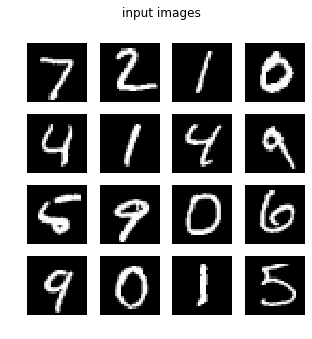

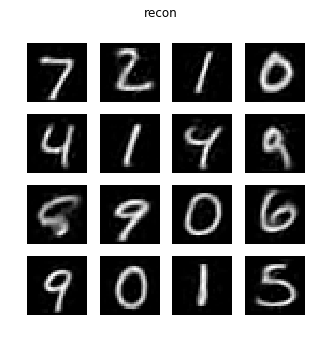

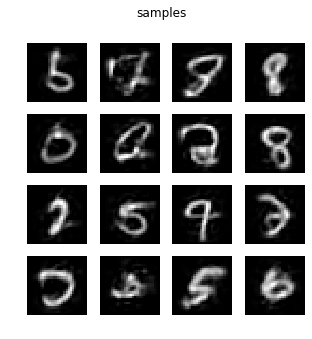

In [11]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

**Fit NVP to posterior for better samples**

In [0]:
nvp_loss = []
ii     = 0
nepoch = 0
learning_rate = 1e-3

In [0]:
#train the nvp
while nepoch<1000:
  if (ii+1)*batch_size>len(x_train): 
    np.random.shuffle(x_train)
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>10:
    learning_rate=1e-5
  if nepoch>200:
    learning_rate=1e-6
  x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
  _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  nvp_loss+=[ll]
  if ii%500==0:
    print(ll)
  ii+=1

9.484911
starting epoch 31
8.66793
8.767904
starting epoch 32
8.8723955
8.914234
starting epoch 33
9.017185
9.010636
starting epoch 34
8.318932
8.543256
starting epoch 35
8.3425455
8.877103
starting epoch 36
8.263573
8.261623
starting epoch 37
8.876207
8.105242
starting epoch 38
8.7
9.535585
starting epoch 39
9.113162


KeyboardInterrupt: ignored

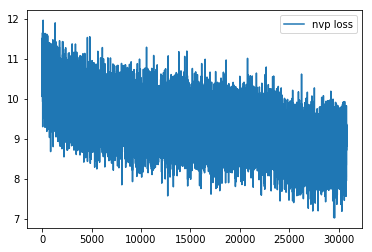

In [0]:
plt.figure()
plot(nvp_loss[::],label='nvp loss')
legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:30.522281 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


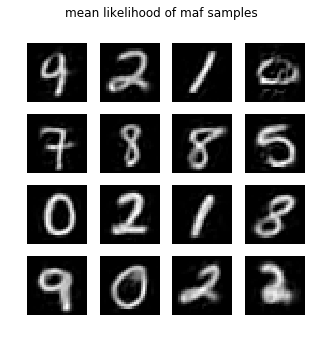

In [12]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [13]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0509 17:01:31.921662 140467102295936 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


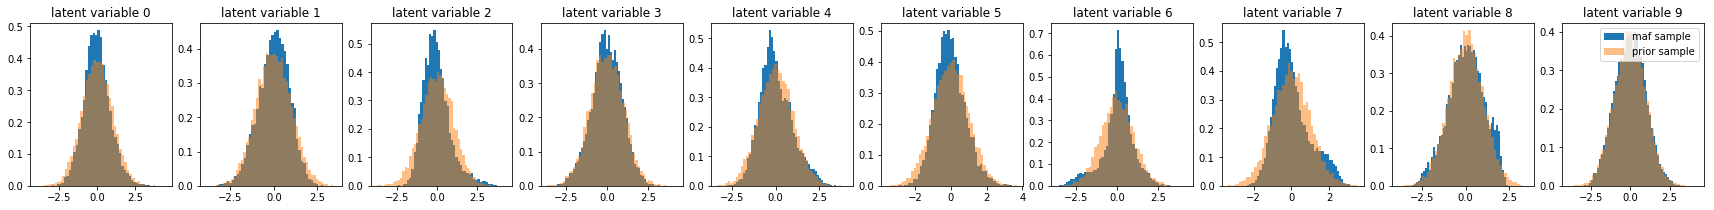

In [14]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

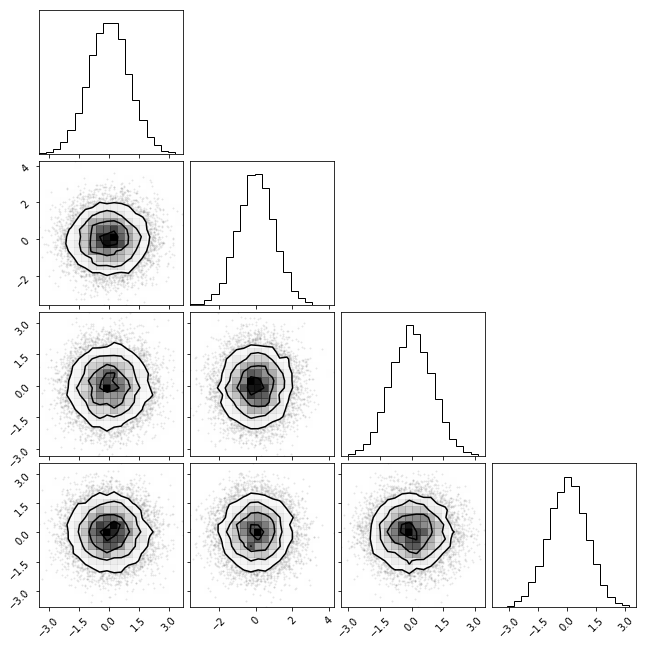

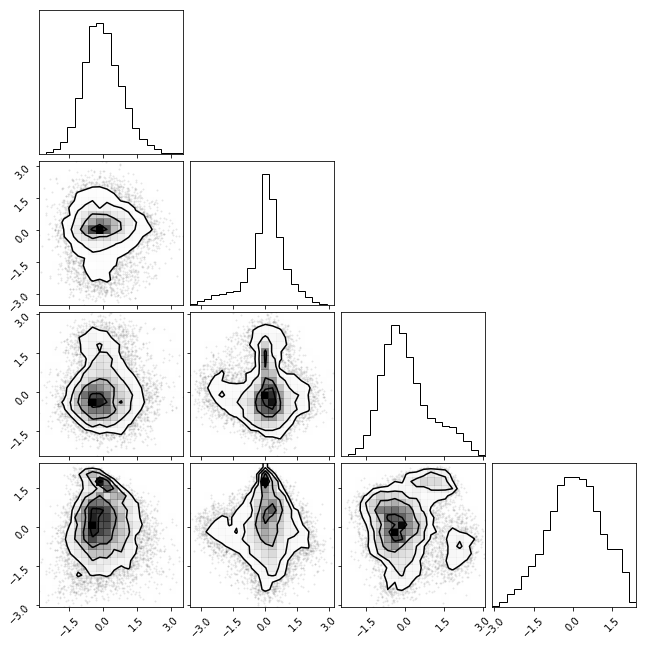

In [15]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])

**Make corrupted data**

In [0]:

mask = np.ones(IMAGE_SHAPE, dtype=int)
# use also 12:18/12:20 -> 4 
#mask[0:28,12:18]=0.
mask = mask.reshape((28*28))
sigma_new = np.ones(mask.shape)*sigma_n
sigma_new[np.where(mask==0)] = sigma_n*1e4
x_true = x_test[6:6+batch_size2]
masked_data = x_true*[mask]
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)
#mask = np.expand_dims(mask, -1)
data = np.expand_dims(masked_data,-1)

**Minimize ELBO for corrupted data and look at samples**

In [0]:
posterior_loss=[]

In [19]:
lrate=1e-2
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo, elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new})
  posterior_loss.append(ll)
  if ii%100==0:
    print(ll)

-528.6223
-535.6491
-524.86816
-526.7951
-536.5007
-534.87695
-514.1245
-533.25146
-513.46375
-534.43536
-523.5495
-520.6334
-531.59045
-527.8497
-528.41956
-527.4218
-530.55786
-533.8088
-530.7088
-532.6213


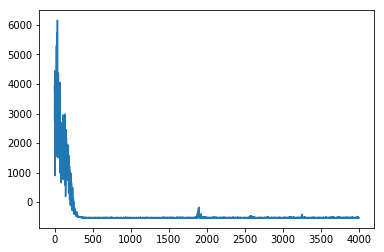

In [20]:
plt.plot(posterior_loss)

In [21]:
mean = sess.run(mean_corr_likelihood,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new})
samples = sess.run(sample_elbo_mean,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new})
print(samples.shape)

(1, 64, 784, 1)


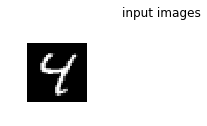

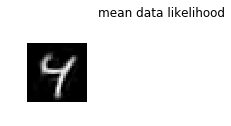

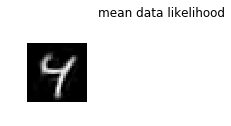

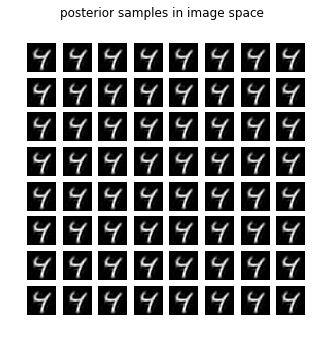

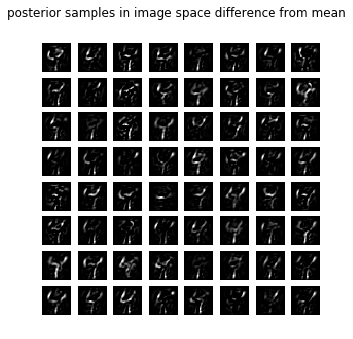

In [22]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]-mean_sample,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()

**find minima with nvp**

0
2664.5308
-550.4725
-543.7013
-551.9068
-553.1627
-551.4027
-543.94165
-543.51263
-547.06824
-540.2199
switching to lr 0.01
-552.46185
-553.7926
-554.452
-553.939
-554.3417
switching to lr 0.001
-554.1342
-554.57007
1
2377.9985
-95.77576
-510.72726
-545.0485
-551.9037
-549.3404
-552.48706
-552.7907
-549.7818
-533.475
switching to lr 0.01
-545.25073
-554.4895
-554.05273
-553.9075
-554.26184
switching to lr 0.001
-554.2123
-554.5705
2
3592.7056
-516.5321
-550.8382
-549.86694
-539.45013
-546.42847
-551.9416
-549.34344
-528.8123
-551.11145
switching to lr 0.01
-550.1671
-554.48236
-554.1255
-554.1484
-554.22784
switching to lr 0.001
-554.1185
-554.56506
3
5347.017
325.6811
-537.14075
-551.32306
-546.40027
-541.40955
-553.144
-551.6402
-553.85693
-551.9126
switching to lr 0.01
-552.27734
-554.4671
-554.34125
-554.32794
-554.0713
switching to lr 0.001
-554.4249
-554.5826
4
3289.3784
1613.4563
1608.1544
1611.9564
1612.4475
1607.5933
1611.9795
1609.4755
1611.8104
1609.4462
switching to lr 0.

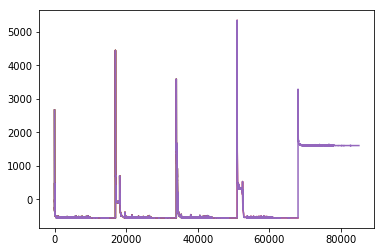

In [23]:
posterior_corr_loss=[]

l_minima=[]
map_minima=[]
for ii in range(5):
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  elif ii==0:
    #starting from truth
    ini = sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})
  else:
    ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for ii in range(5000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for ii in range(2000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  plot(posterior_corr_loss,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new})]

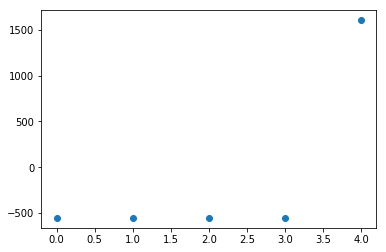

In [25]:
plt.figure()
plt.plot(np.arange(5),l_minima,ls='',marker='o')
plt.show()

In [0]:
import pickle
pickle.dump([l_minima,map_minima],open(minima_path+'nvp_minima_uncorrupted.pkl','wb'))
l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima_uncorrupted.pkl','rb'))

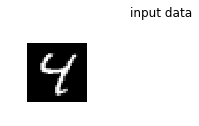

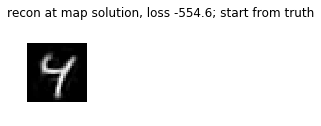

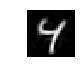

eigenvalues before and after inverse, approx hessian
[array([[9.9746758e-01, 9.9804777e-01, 9.9962598e-01, 9.9990016e-01,
        1.0000008e+00, 1.0000972e+00, 1.0005385e+00, 1.0016727e+00,
        1.0053425e+00, 2.6792722e+05]], dtype=float32), array([[3.6954880e-06, 9.9600589e-01, 9.9877828e-01, 9.9961734e-01,
        9.9967313e-01, 1.0000024e+00, 1.0002155e+00, 1.0005053e+00,
        1.0007094e+00, 1.0049655e+00]], dtype=float32)]


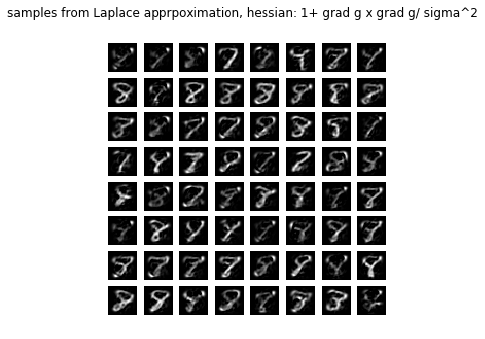

(1, 10, 10)


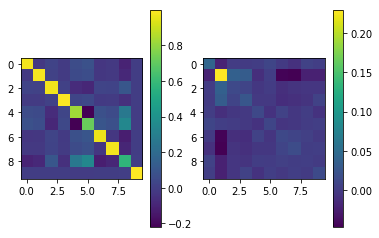

eigenvalues before and after inverse, full hessian
[array([[3.74956894e+00, 1.97798138e+01, 3.12073669e+01, 4.63114815e+01,
        1.08413651e+02, 5.75567078e+02, 8.73832092e+02, 2.95649097e+03,
        6.32625439e+03, 1.03234836e+05]], dtype=float32), array([[9.6855365e-06, 1.5806567e-04, 3.3823369e-04, 1.1443794e-03,
        1.7374149e-03, 9.2239007e-03, 2.1592440e-02, 3.2040793e-02,
        5.0557237e-02, 2.6668146e-01]], dtype=float32)]


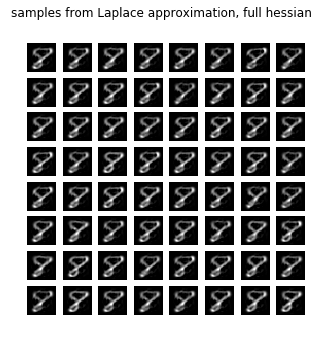

2848.4326
-518.13934
-529.964
-533.5684
-533.7516
-536.2777
-529.88446
-526.4979
-534.076
-529.00085
-517.08575
-534.33453
-519.8612
-529.34424
-522.49414
-527.32196
-524.18726
-527.54175
-519.4216
-525.7035


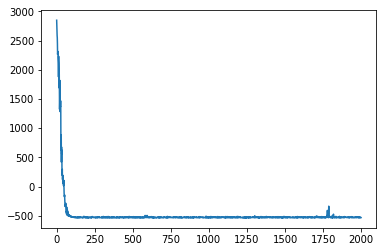

variance of VI [[-0.03534352  0.03394542  0.03395863  0.03477522 -0.01606166  0.04532802
   0.02075924  0.01665818 -0.02233608  0.02364686]]


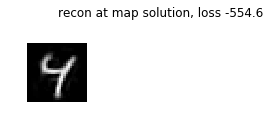

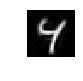

eigenvalues before and after inverse, approx hessian
[array([[9.8748243e-01, 9.9817890e-01, 9.9958575e-01, 9.9982506e-01,
        9.9995941e-01, 1.0000126e+00, 1.0001630e+00, 1.0006558e+00,
        1.0044616e+00, 2.6864862e+05]], dtype=float32), array([[3.6954880e-06, 9.9644315e-01, 9.9911267e-01, 9.9976623e-01,
        9.9993002e-01, 1.0000178e+00, 1.0001829e+00, 1.0003197e+00,
        1.0006003e+00, 1.0047629e+00]], dtype=float32)]


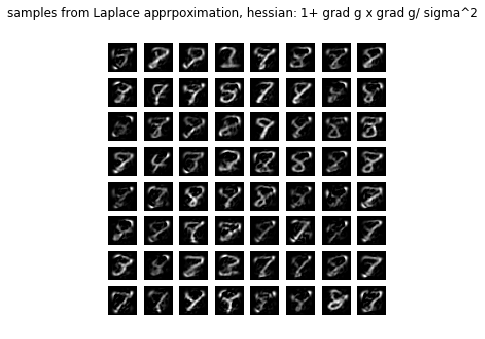

(1, 10, 10)


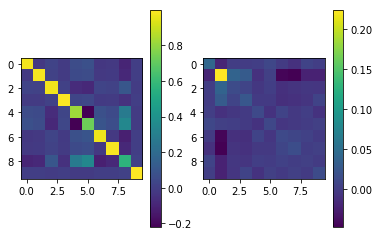

eigenvalues before and after inverse, full hessian
[array([[3.8404207e+00, 1.9588911e+01, 3.1357126e+01, 4.4974037e+01,
        1.1004763e+02, 5.7751483e+02, 8.6384576e+02, 3.0309871e+03,
        6.2371074e+03, 1.0396553e+05]], dtype=float32), array([[9.6183539e-06, 1.6033137e-04, 3.2992577e-04, 1.1576170e-03,
        1.7315643e-03, 9.0869600e-03, 2.2234431e-02, 3.1887528e-02,
        5.1050447e-02, 2.6036531e-01]], dtype=float32)]


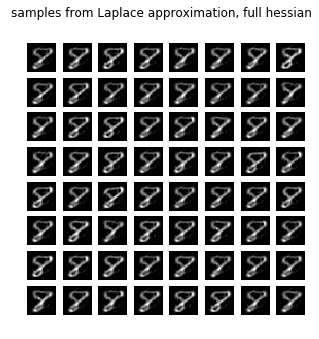

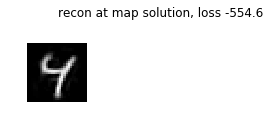

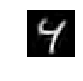

eigenvalues before and after inverse, approx hessian
[array([[9.9735254e-01, 9.9910271e-01, 9.9952120e-01, 9.9974036e-01,
        9.9998587e-01, 1.0002084e+00, 1.0005444e+00, 1.0031621e+00,
        1.0169466e+00, 2.7272059e+05]], dtype=float32), array([[3.6954880e-06, 9.9354285e-01, 9.9917400e-01, 9.9958318e-01,
        9.9970108e-01, 9.9985570e-01, 1.0000143e+00, 1.0004083e+00,
        1.0007006e+00, 1.0046737e+00]], dtype=float32)]


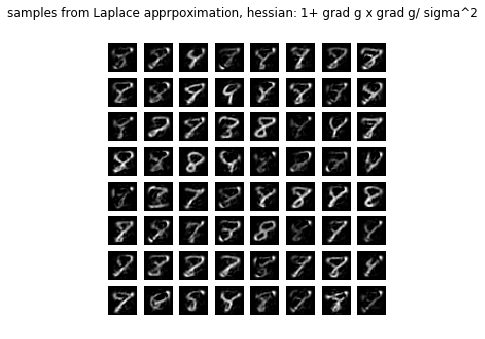

(1, 10, 10)


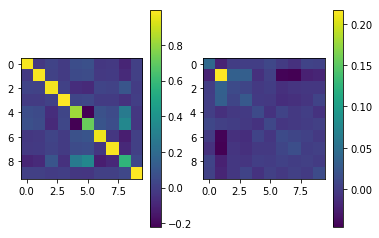

eigenvalues before and after inverse, full hessian
[array([[3.9561760e+00, 1.9110857e+01, 3.2220116e+01, 4.5217205e+01,
        1.0674364e+02, 5.5536890e+02, 9.1429846e+02, 2.9957412e+03,
        6.1864595e+03, 1.0423448e+05]], dtype=float32), array([[9.5929554e-06, 1.6164257e-04, 3.3380440e-04, 1.0937292e-03,
        1.8006011e-03, 9.3682110e-03, 2.2115281e-02, 3.1036448e-02,
        5.2327435e-02, 2.5277731e-01]], dtype=float32)]


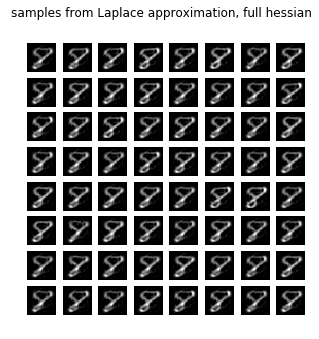

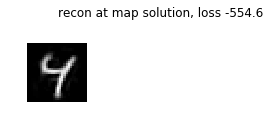

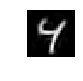

eigenvalues before and after inverse, approx hessian
[array([[9.9647683e-01, 9.9910545e-01, 9.9983668e-01, 9.9994838e-01,
        1.0000088e+00, 1.0001433e+00, 1.0002247e+00, 1.0012597e+00,
        1.0040735e+00, 2.1110402e+05]], dtype=float32), array([[4.6491623e-06, 9.9626660e-01, 9.9875623e-01, 9.9972510e-01,
        9.9984801e-01, 9.9996215e-01, 1.0000039e+00, 1.0001172e+00,
        1.0005128e+00, 1.0011541e+00]], dtype=float32)]


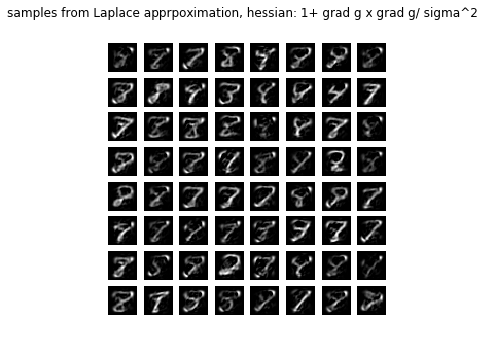

(1, 10, 10)


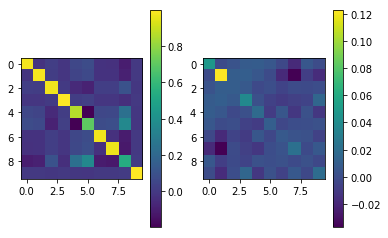

eigenvalues before and after inverse, full hessian
[array([[6.9544573e+00, 1.6111441e+01, 1.9314953e+01, 3.4779045e+01,
        1.0186282e+02, 5.3668976e+02, 8.2893579e+02, 2.8261445e+03,
        6.0939424e+03, 1.0371363e+05]], dtype=float32), array([[9.6465492e-06, 1.6410720e-04, 3.5384169e-04, 1.2063694e-03,
        1.8632748e-03, 9.8171411e-03, 2.8752888e-02, 5.1771231e-02,
        6.2063340e-02, 1.4379013e-01]], dtype=float32)]


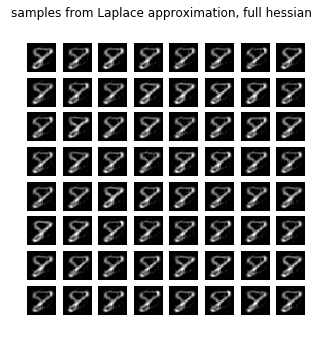

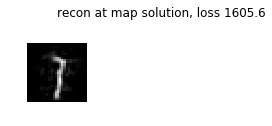

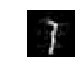

eigenvalues before and after inverse, approx hessian
[array([[9.9964303e-01, 9.9984926e-01, 9.9997336e-01, 9.9999994e-01,
        1.0000020e+00, 1.0000129e+00, 1.0000165e+00, 1.0000818e+00,
        1.0001233e+00, 1.1615400e+04]], dtype=float32), array([[8.6128712e-05, 9.9980915e-01, 9.9992263e-01, 9.9997175e-01,
        9.9997991e-01, 9.9999833e-01, 1.0000001e+00, 1.0000156e+00,
        1.0000366e+00, 1.0000578e+00]], dtype=float32)]


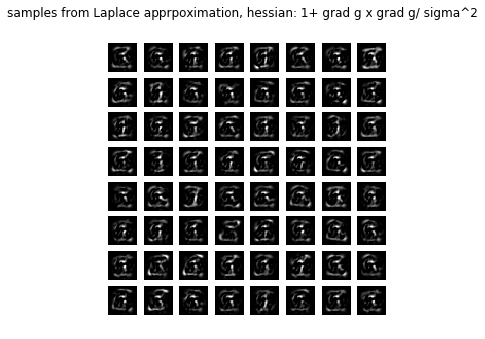

(1, 10, 10)


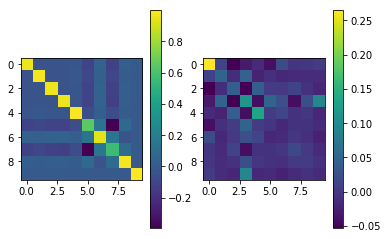

eigenvalues before and after inverse, full hessian
[array([[-8.5836067e+00,  3.4524138e+00,  4.1454616e+00,  8.8660192e+00,
         1.9341295e+01,  1.2975475e+02,  4.0941632e+02,  3.5007354e+03,
         3.7719963e+03,  1.1882633e+04]], dtype=float32), array([[-1.1650969e-01,  8.4170337e-05,  2.6510979e-04,  2.8562846e-04,
         2.4424943e-03,  7.7068345e-03,  5.1702783e-02,  1.1278697e-01,
         2.4122302e-01,  2.8965241e-01]], dtype=float32)]
full hessian fails


In [27]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis=[] 
# order minima by loss function value
l_minima  = np.asarray(l_minima)
map_minima= np.asarray(map_minima)
order     = np.argsort(l_minima)

for ii,ini_ in enumerate(map_minima[order]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})

  figure(figsize=(5,5))
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_minima[ii])
  else:
    suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()

  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  
  # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})]
  
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

  # get samples 
  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  
  ## plot sigma
  
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True}))
  try:
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')

#do vae on corrupted data with mean of posterior set to MAP values
  if ii ==0:
    _ = sess.run(update4,feed_dict={x_corr: data, sigma_corr:sigma_new})   
    lrate=1e-2
    elbo_2_loss=[]
    for ii in range(2000):
      _, ll = sess.run([opt_op_elbo2, elbo],feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new})
      elbo_2_loss.append(ll)
      if ii%100==0:
        print(ll)
    plt.figure()
    plt.plot(elbo_2_loss)
    plt.show()
    
    elbo_var = sess.run(sigma_elbo,feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new})
    print('variance of VI', elbo_var)

W0509 17:08:44.800773 140467102295936 legend.py:1289] No handles with labels found to put in legend.


(5, 1, 1, 10)
(5, 1, 1, 10)
(5, 1, 1, 10)
(5, 1, 1, 10)
(5, 1, 1, 10)


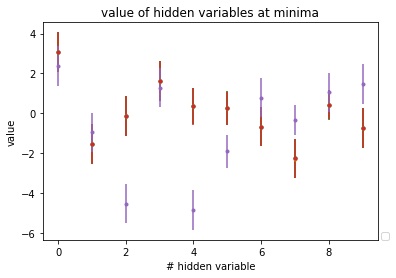

In [28]:
varis=np.asarray(varis)
map_minima=np.asarray(map_minima)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima)):
  print(map_minima.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

**minima without nvp**

0
1845.7347
-560.5157
-558.5706
-554.8505
-561.0613
-560.94684
-560.9537
-560.4344
-560.816
-561.21136
1
3386.1272
-558.23804
-556.70734
-558.2914
-561.0714
-560.9419
-560.8113
-560.68414
-560.7339
-561.21173
2
3247.2896
-557.03204
-558.7116
-558.6931
-561.04144
-560.8343
-561.16675
-561.0797
-560.66425
-561.208
3
2246.4128
-558.042
-559.2512
-557.28345
-560.3591
-561.0633
-560.4734
-561.0527
-560.93365
-561.20605
4
4281.95
1368.1921
1368.2524
1367.7267
1367.2461
1367.3971
1367.5111
1367.2697
1367.5278
1367.1908


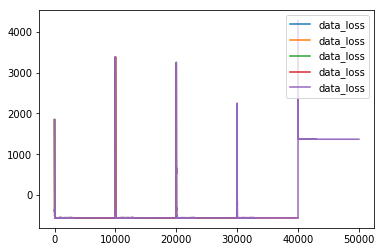

In [29]:
l_minima_old=[]
map_minima_old=[]
posterior_loss3=[]
for ii in range(5):
  print(ii)
  ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, nvp_prior: False, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  for ii in range(5000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-4
  for ii in range(2000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  l_minima_old+=[ll]
  map_minima_old+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False, lr:lrate})]
  plot(posterior_loss3,label='data_loss')
  legend()

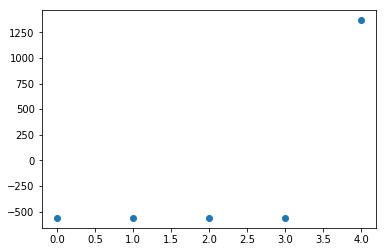

In [31]:
plt.figure()
plt.plot(np.arange(5),l_minima_old,ls='',marker='o')
plt.show()

In [0]:
import pickle
pickle.dump([l_minima_old,map_minima_old],open(minima_path+'minima_nonvp_uncorrupted.pkl','wb'))
l_minima_old,map_minima_old = pickle.load(open(minima_path+'minima_nonvp_uncorrupted.pkl','rb'))

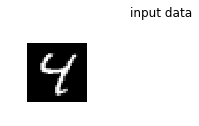

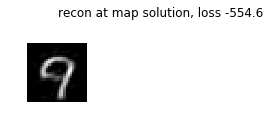

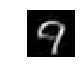

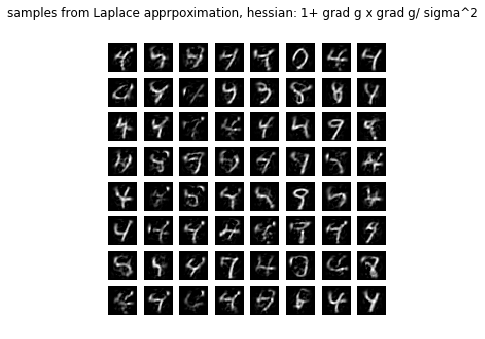

<Figure size 360x360 with 0 Axes>

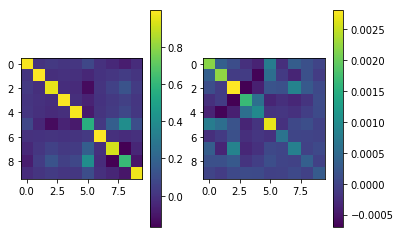

eigenvalues before and after inverse, full hessian
[array([[ 239.61421,  301.80478,  469.99026,  587.7737 ,  699.3838 ,
        1710.6104 , 1965.2966 , 3036.9934 , 4026.5652 , 4193.9507 ]],
      dtype=float32), array([[0.00023844, 0.00024835, 0.00032927, 0.00050883, 0.00058459,
        0.00142983, 0.00170133, 0.0021277 , 0.0033134 , 0.00417338]],
      dtype=float32)]


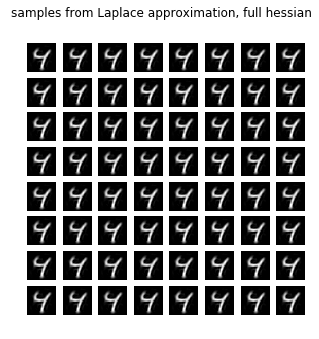

2852.1006
-498.26038
-517.51904
-532.94147
-518.73456
-532.4433
-532.981
-530.36487
-528.83606
-523.07806
-532.0829
-524.55365
-526.36383
-515.8989
-529.04517
-529.09906
-533.1338
-524.34985
-535.4463
-531.1338


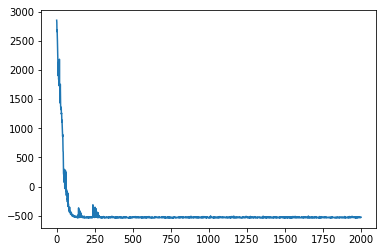

variance of VI [[-0.02790031  0.041244    0.03273426  0.02943669 -0.01599805  0.04282491
  -0.024839    0.01532788  0.01054687 -0.01750223]]


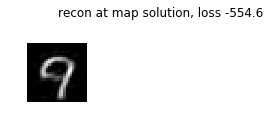

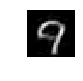

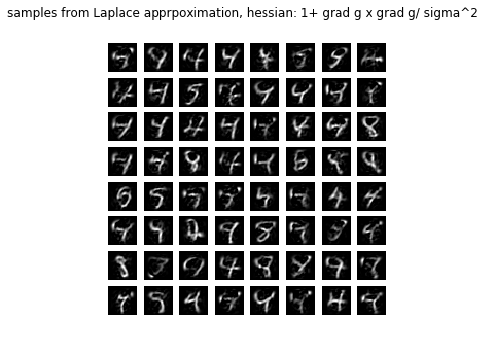

<Figure size 360x360 with 0 Axes>

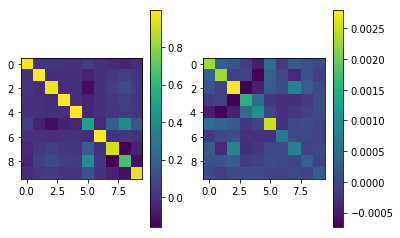

eigenvalues before and after inverse, full hessian
[array([[ 250.57684,  317.66528,  430.00555,  525.7719 ,  752.4584 ,
        1602.3162 , 1878.4353 , 2833.5518 , 3392.0085 , 4179.1396 ]],
      dtype=float32), array([[0.00023928, 0.00029481, 0.00035291, 0.00053236, 0.0006241 ,
        0.00132898, 0.00190197, 0.00232555, 0.00314797, 0.00399079]],
      dtype=float32)]


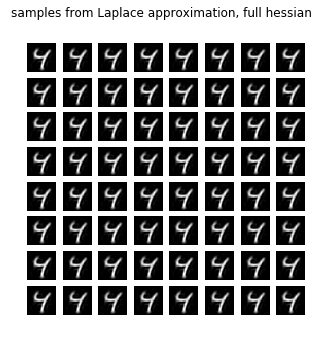

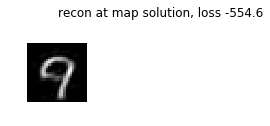

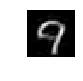

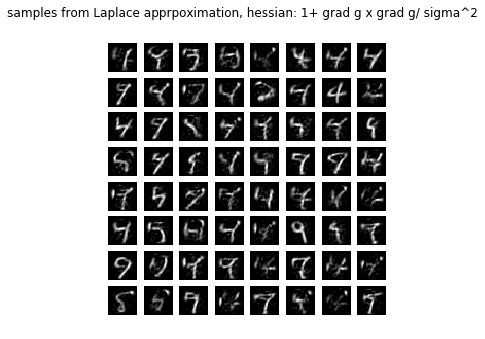

<Figure size 360x360 with 0 Axes>

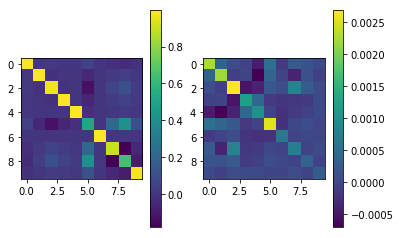

eigenvalues before and after inverse, full hessian
[array([[ 271.76257,  324.1806 ,  447.5287 ,  531.46423,  809.1859 ,
        1669.4945 , 1882.1958 , 3065.297  , 4035.3047 , 4210.7686 ]],
      dtype=float32), array([[0.00023749, 0.00024781, 0.00032623, 0.00053129, 0.00059898,
        0.00123581, 0.00188159, 0.00223449, 0.0030847 , 0.00367968]],
      dtype=float32)]


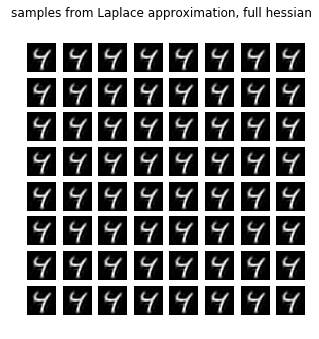

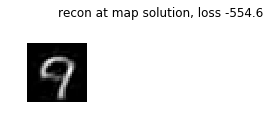

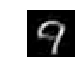

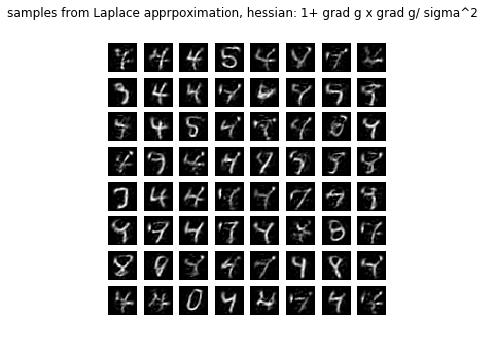

<Figure size 360x360 with 0 Axes>

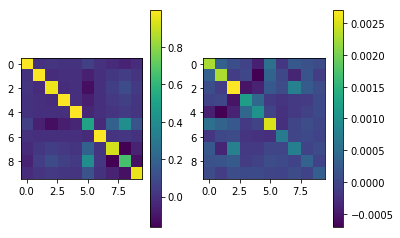

eigenvalues before and after inverse, full hessian
[array([[ 275.51395,  322.84042,  433.22867,  525.5418 ,  829.83124,
        1614.7778 , 1877.8138 , 3004.1963 , 3450.2815 , 4203.1377 ]],
      dtype=float32), array([[0.00023792, 0.00028983, 0.00033287, 0.00053253, 0.00061928,
        0.00120506, 0.0019028 , 0.00230825, 0.00309751, 0.00362958]],
      dtype=float32)]


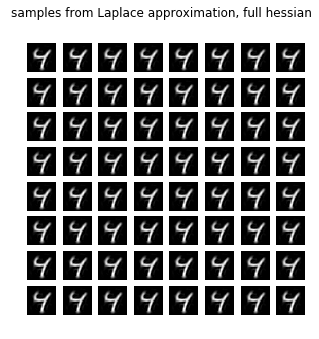

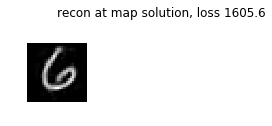

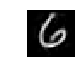

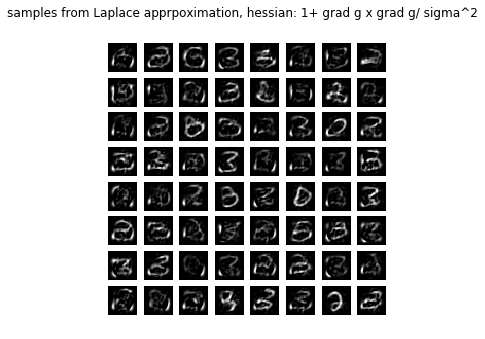

<Figure size 360x360 with 0 Axes>

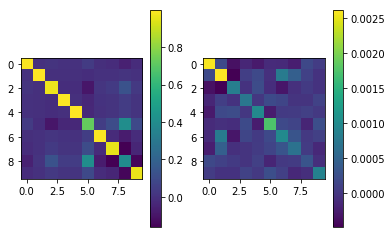

eigenvalues before and after inverse, full hessian
[array([[ 306.27264,  365.1921 ,  496.12384,  964.7427 , 1114.5037 ,
        1468.2222 , 1556.2028 , 1968.9252 , 2678.3406 , 4029.786  ]],
      dtype=float32), array([[0.00024815, 0.00037337, 0.00050789, 0.00064259, 0.0006811 ,
        0.00089726, 0.00103655, 0.00201563, 0.00273828, 0.00326506]],
      dtype=float32)]


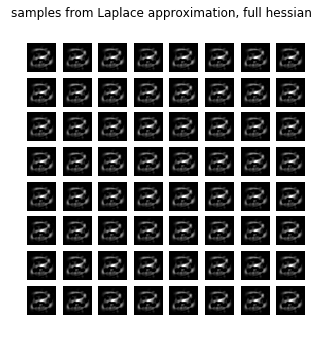

In [33]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

#order minimia
varis=[] 
l_minima_old=np.asarray(l_minima_old)
map_minima_old=np.asarray(map_minima_old)
order = np.argsort(l_minima_old)


for ii,ini_ in enumerate(map_minima_old[order]):
  
  # set MAP
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
 
  # Laplace approximation
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior:False})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})]

  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  figure(figsize=(5,5))
  #mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))

  ## plot sigma
  
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

  plt.figure()
  subplot(1,2,1)
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
    
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False}))
  try:
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


#do vae on corrupted data with mean of posterior set to MAP values
  if ii ==0:
    _ = sess.run(update4,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False})   
    lrate=1e-2
    elbo_2_loss=[]
    for ii in range(2000):
      _, ll = sess.run([opt_op_elbo2, elbo],feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
      elbo_2_loss.append(ll)
      if ii%100==0:
        print(ll)
    plt.figure()
    plt.plot(elbo_2_loss)
    plt.show()
    
    elbo_var = sess.run(sigma_elbo,feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
    print('variance of VI', elbo_var)    


W0509 17:14:25.258591 140467102295936 legend.py:1289] No handles with labels found to put in legend.


(5, 1, 1, 10)
(5, 1, 1, 10)
(5, 1, 1, 10)
(5, 1, 1, 10)
(5, 1, 1, 10)


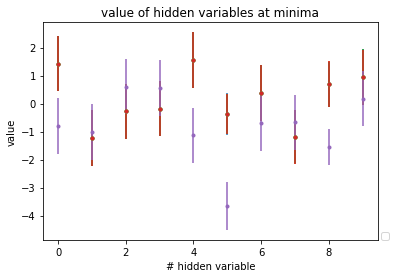

In [34]:
varis=np.asarray(varis)
map_minima_old=np.asarray(map_minima_old)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima_old)):
  print(map_minima_old.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima_old[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

**do vae on corrupted data with mean of posterior set to MAP values**

---

